In [21]:
import os
import json
import shap
import joblib
import xgboost as xgb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [20]:
MERGED_CSV_PATH = r"C:\Users\smpat\Documents\7th Sem Project\combined_cicids2018.csv"



In [17]:
# Output directory
ARTIFACT_DIR = "artifacts_testing"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

libsvm_train = os.path.join(ARTIFACT_DIR, "train.buffer")
libsvm_test = os.path.join(ARTIFACT_DIR, "test.buffer")

In [ ]:
import os

ARTIFACT_DIR = "/path/to/artifact/dir"  # Change to your actual folder




In [28]:
# 2. Helper Functions

def preprocess_chunk(df):
    """Clean and preprocess one chunk of CICIDS2018 data"""
    df = df.dropna(axis=1, how='all')  # drop empty columns

    # drop non-numeric
    df = df.select_dtypes(include=[np.number, np.int64, np.float64])

    # replace inf/-inf with nan
    df = df.replace([np.inf, -np.inf], np.nan)

    # fill missing with 0
    df = df.fillna(0)

    # drop constant columns
    nunique = df.nunique()
    df = df.loc[:, nunique > 1]

    return df

def map_labels(label):
    """Map labels to 5 classes"""
    label = label.lower()
    if "benign" in label:
        return "Benign"
    elif "dos" in label:
        return "DoS"
    elif "ddos" in label:
        return "DDoS"
    elif "bruteforce" in label or "brute force" in label:
        return "BruteForce"
    else:
        return "Exploits"

In [22]:
from sklearn.preprocessing import LabelEncoder
import gc

In [9]:
# ===== FIRST PASS: Gather all labels AND features =====
print("🔍 First pass: collecting unique labels and all feature columns...")
label_set = set()
all_feature_columns = set()

reader = pd.read_csv(MERGED_CSV_PATH, chunksize=50000)
for chunk in reader:
    if 'Label' not in chunk.columns:
        raise ValueError("CSV must contain 'Label' column")
    
    # Collect labels
    label_set.update(chunk['Label'].astype(str).unique())
    
    # Collect all possible feature columns after preprocessing
    chunk_processed = preprocess_chunk(chunk.drop(columns=['Label']))
    all_feature_columns.update(chunk_processed.columns)

# Create consistent feature list
all_features = sorted(list(all_feature_columns))
print(f"✅ Found {len(all_features)} consistent features across all chunks.")

# Fit label encoder on all labels
le = LabelEncoder()
le.fit(list(label_set))
print(f"✅ Found {len(le.classes_)} unique labels.")

# ===== SECOND PASS: Convert to libsvm =====
print("🔍 Second pass: processing chunks and accumulating data...")
reader = pd.read_csv(MERGED_CSV_PATH, chunksize=50000)

# Lists to accumulate all training and testing data
X_train_all = []
X_test_all = []
y_train_all = []
y_test_all = []

for i, chunk in enumerate(reader):
    print(f"🚧 Processing chunk {i+1}...")

    # Extract and encode labels
    raw_labels = chunk['Label'].astype(str)
    labels = le.transform(raw_labels)
    chunk = chunk.drop(columns=['Label'])

    # Preprocess numeric features
    chunk = preprocess_chunk(chunk)

    # Ensure consistent columns across all chunks
    # This is crucial - all chunks must have the same features
    chunk = chunk.reindex(columns=all_features, fill_value=0)
    
    print(f"   Chunk {i+1} shape after preprocessing: {chunk.shape}")

    # Split into train/test
    try:
        X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
            chunk.values, labels, test_size=0.2, random_state=42, 
            stratify=labels if len(np.unique(labels)) > 1 else None
        )
    except ValueError as e:
        print(f"   Warning: Stratification failed for chunk {i+1}, using random split")
        X_temp_train, X_temp_test, y_temp_train, y_temp_test = train_test_split(
            chunk.values, labels, test_size=0.2, random_state=42
        )

    # Accumulate data
    X_train_all.append(X_temp_train)
    X_test_all.append(X_temp_test)
    y_train_all.append(y_temp_train)
    y_test_all.append(y_temp_test)
    
    gc.collect()
    print(f"   ✅ Chunk {i+1} processed successfully")

# ===== COMBINE ALL DATA =====
print("🔧 Combining all chunks...")

# Concatenate all chunks
X_train_final = np.vstack(X_train_all)
X_test_final = np.vstack(X_test_all)
y_train_final = np.concatenate(y_train_all)
y_test_final = np.concatenate(y_test_all)

print(f"✅ Final training set shape: {X_train_final.shape}")
print(f"✅ Final test set shape: {X_test_final.shape}")

# Create and save DMatrix objects
print("💾 Creating and saving DMatrix objects...")
dtrain_final = xgb.DMatrix(X_train_final, label=y_train_final)
dtest_final = xgb.DMatrix(X_test_final, label=y_test_final)

# Save binary files
dtrain_final.save_binary(libsvm_train)
dtest_final.save_binary(libsvm_test)

# Save feature names
with open(os.path.join(ARTIFACT_DIR, "feature_names.json"), "w") as f:
    json.dump(all_features, f)

# Save label mapping
label_mapping = {cls: int(le.transform([cls])[0]) for cls in le.classes_}
with open(os.path.join(ARTIFACT_DIR, "label_mapping.json"), "w") as f:
    json.dump(label_mapping, f)

print("✅ Finished converting CSV -> LibSVM. Labels encoded and mapping saved.")
print(f"📊 Final dataset stats:")
print(f"   - Training samples: {len(y_train_final)}")
print(f"   - Test samples: {len(y_test_final)}")
print(f"   - Features: {len(all_features)}")
print(f"   - Classes: {len(le.classes_)}")


🔍 First pass: collecting unique labels and all feature columns...


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,2

✅ Found 70 consistent features across all chunks.
✅ Found 16 unique labels.
🔍 Second pass: processing chunks and accumulating data...
🚧 Processing chunk 1...
   Chunk 1 shape after preprocessing: (50000, 70)
   ✅ Chunk 1 processed successfully
🚧 Processing chunk 2...
   Chunk 2 shape after preprocessing: (50000, 70)
   ✅ Chunk 2 processed successfully
🚧 Processing chunk 3...
   Chunk 3 shape after preprocessing: (50000, 70)
   ✅ Chunk 3 processed successfully
🚧 Processing chunk 4...
   Chunk 4 shape after preprocessing: (50000, 70)
   ✅ Chunk 4 processed successfully
🚧 Processing chunk 5...
   Chunk 5 shape after preprocessing: (50000, 70)
   ✅ Chunk 5 processed successfully
🚧 Processing chunk 6...
   Chunk 6 shape after preprocessing: (50000, 70)
   ✅ Chunk 6 processed successfully
🚧 Processing chunk 7...
   Chunk 7 shape after preprocessing: (50000, 70)
   ✅ Chunk 7 processed successfully
🚧 Processing chunk 8...
   Chunk 8 shape after preprocessing: (50000, 70)
   ✅ Chunk 8 processed

Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 62...
   Chunk 62 shape after preprocessing: (50000, 70)
   ✅ Chunk 62 processed successfully
🚧 Processing chunk 63...
   Chunk 63 shape after preprocessing: (50000, 70)
   ✅ Chunk 63 processed successfully
🚧 Processing chunk 64...
   Chunk 64 shape after preprocessing: (50000, 70)
   ✅ Chunk 64 processed successfully
🚧 Processing chunk 65...
   Chunk 65 shape after preprocessing: (50000, 70)
   ✅ Chunk 65 processed successfully
🚧 Processing chunk 66...
   Chunk 66 shape after preprocessing: (50000, 70)
   ✅ Chunk 66 processed successfully
🚧 Processing chunk 67...
   Chunk 67 shape after preprocessing: (50000, 70)
   ✅ Chunk 67 processed successfully
🚧 Processing chunk 68...
   Chunk 68 shape after preprocessing: (50000, 70)
   ✅ Chunk 68 processed successfully
🚧 Processing chunk 69...
   Chunk 69 shape after preprocessing: (50000, 70)
   ✅ Chunk 69 processed successfully
🚧 Processing chunk 70...
   Chunk 70 shape after preprocessing: (50000, 70)
   ✅ Chunk 70 proces

Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 127...
   Chunk 127 shape after preprocessing: (50000, 70)
   ✅ Chunk 127 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 128...
   Chunk 128 shape after preprocessing: (50000, 70)
   ✅ Chunk 128 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 129...
   Chunk 129 shape after preprocessing: (50000, 70)
   ✅ Chunk 129 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 130...
   Chunk 130 shape after preprocessing: (50000, 70)
   ✅ Chunk 130 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 131...
   Chunk 131 shape after preprocessing: (50000, 70)
   ✅ Chunk 131 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 132...
   Chunk 132 shape after preprocessing: (50000, 70)
   ✅ Chunk 132 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 133...
   Chunk 133 shape after preprocessing: (50000, 70)
   ✅ Chunk 133 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 134...
   Chunk 134 shape after preprocessing: (50000, 70)
   ✅ Chunk 134 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 135...
   Chunk 135 shape after preprocessing: (50000, 70)
   ✅ Chunk 135 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 136...
   Chunk 136 shape after preprocessing: (50000, 70)
   ✅ Chunk 136 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 137...
   Chunk 137 shape after preprocessing: (50000, 70)
   ✅ Chunk 137 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 138...
   Chunk 138 shape after preprocessing: (50000, 70)
   ✅ Chunk 138 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 139...
   Chunk 139 shape after preprocessing: (50000, 70)
   ✅ Chunk 139 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 140...
   Chunk 140 shape after preprocessing: (50000, 70)
   ✅ Chunk 140 processed successfully
🚧 Processing chunk 141...
   Chunk 141 shape after preprocessing: (50000, 70)
   ✅ Chunk 141 processed successfully
🚧 Processing chunk 142...
   Chunk 142 shape after preprocessing: (50000, 70)
   ✅ Chunk 142 processed successfully
🚧 Processing chunk 143...
   Chunk 143 shape after preprocessing: (50000, 70)
   ✅ Chunk 143 processed successfully
🚧 Processing chunk 144...
   Chunk 144 shape after preprocessing: (50000, 70)
   ✅ Chunk 144 processed successfully


Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.


🚧 Processing chunk 145...
   Chunk 145 shape after preprocessing: (50000, 70)
   ✅ Chunk 145 processed successfully
🚧 Processing chunk 146...
   Chunk 146 shape after preprocessing: (50000, 70)
   ✅ Chunk 146 processed successfully
🚧 Processing chunk 147...
   Chunk 147 shape after preprocessing: (50000, 70)
   ✅ Chunk 147 processed successfully
🚧 Processing chunk 148...
   Chunk 148 shape after preprocessing: (50000, 70)
   ✅ Chunk 148 processed successfully
🚧 Processing chunk 149...
   Chunk 149 shape after preprocessing: (50000, 70)
   ✅ Chunk 149 processed successfully
🚧 Processing chunk 150...
   Chunk 150 shape after preprocessing: (50000, 70)
   ✅ Chunk 150 processed successfully
🚧 Processing chunk 151...
   Chunk 151 shape after preprocessing: (50000, 70)
   ✅ Chunk 151 processed successfully
🚧 Processing chunk 152...
   Chunk 152 shape after preprocessing: (50000, 70)
   ✅ Chunk 152 processed successfully
🚧 Processing chunk 153...
   Chunk 153 shape after preprocessing: (50000

   Chunk 215 shape after preprocessing: (50000, 70)
   ✅ Chunk 215 processed successfully
🚧 Processing chunk 216...
   Chunk 216 shape after preprocessing: (50000, 70)
   ✅ Chunk 216 processed successfully
🚧 Processing chunk 217...
   Chunk 217 shape after preprocessing: (50000, 70)
   ✅ Chunk 217 processed successfully
🚧 Processing chunk 218...
   Chunk 218 shape after preprocessing: (50000, 70)
   ✅ Chunk 218 processed successfully
🚧 Processing chunk 219...
   Chunk 219 shape after preprocessing: (50000, 70)
   ✅ Chunk 219 processed successfully
🚧 Processing chunk 220...
   Chunk 220 shape after preprocessing: (50000, 70)
   ✅ Chunk 220 processed successfully
🚧 Processing chunk 221...
   Chunk 221 shape after preprocessing: (50000, 70)
   ✅ Chunk 221 processed successfully
🚧 Processing chunk 222...
   Chunk 222 shape after preprocessing: (50000, 70)
   ✅ Chunk 222 processed successfully
🚧 Processing chunk 223...
   Chunk 223 shape after preprocessing: (50000, 70)
   ✅ Chunk 223 proce

   ✅ Chunk 285 processed successfully
🚧 Processing chunk 286...
   Chunk 286 shape after preprocessing: (50000, 70)
   ✅ Chunk 286 processed successfully
🚧 Processing chunk 287...
   Chunk 287 shape after preprocessing: (50000, 70)
   ✅ Chunk 287 processed successfully
🚧 Processing chunk 288...
   Chunk 288 shape after preprocessing: (50000, 70)
   ✅ Chunk 288 processed successfully
🚧 Processing chunk 289...
   Chunk 289 shape after preprocessing: (50000, 70)
   ✅ Chunk 289 processed successfully
🚧 Processing chunk 290...
   Chunk 290 shape after preprocessing: (50000, 70)
   ✅ Chunk 290 processed successfully
🚧 Processing chunk 291...
   Chunk 291 shape after preprocessing: (50000, 70)
   ✅ Chunk 291 processed successfully
🚧 Processing chunk 292...
   Chunk 292 shape after preprocessing: (50000, 70)
   ✅ Chunk 292 processed successfully
🚧 Processing chunk 293...
   Chunk 293 shape after preprocessing: (50000, 70)
   ✅ Chunk 293 processed successfully
🚧 Processing chunk 294...
   Chunk

In [23]:
import xgboost as xgb

train_path = "C:/Users/smpat/Documents/7th Sem Project/artifacts_testing/train.buffer"
test_path  = "C:/Users/smpat/Documents/7th Sem Project/artifacts_testing/test.buffer"

dtrain_final = xgb.DMatrix(train_path)
dtest_final = xgb.DMatrix(test_path)


In [24]:
import json

with open("C:/Users/smpat/Documents/7th Sem Project/artifacts_testing/feature_names.json") as f:
    all_features = json.load(f)

with open("C:/Users/smpat/Documents/7th Sem Project/artifacts_testing/label_mapping.json") as f:
    label_mapping = json.load(f)


In [14]:
# Step 4: Train XGBoost Model
params = {
    "objective": "multi:softmax",   # or "multi:softprob" for probabilities
    "num_class": len(label_mapping),  # number of unique attack types
    "eval_metric": "mlogloss",
    "max_depth": 6,
    "eta": 0.3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist"           # efficient for large datasets
}

num_round = 30  # number of boosting rounds
evallist = [(dtrain_final, "train"), (dtest_final, "eval")]


In [15]:
bst = xgb.train(params, dtrain_final, num_round, evallist, early_stopping_rounds=10)


y_pred = bst.predict(dtest_final)
y_true = dtest_final.get_label()

print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

Pass `evals` as keyword args.


[0]	train-mlogloss:0.84599	eval-mlogloss:0.84572
[1]	train-mlogloss:0.61346	eval-mlogloss:0.61323
[2]	train-mlogloss:0.46132	eval-mlogloss:0.46109
[3]	train-mlogloss:0.35438	eval-mlogloss:0.35418
[4]	train-mlogloss:0.27799	eval-mlogloss:0.27779
[5]	train-mlogloss:0.22251	eval-mlogloss:0.22231
[6]	train-mlogloss:0.18141	eval-mlogloss:0.18121
[7]	train-mlogloss:0.15147	eval-mlogloss:0.15127
[8]	train-mlogloss:0.12919	eval-mlogloss:0.12900
[9]	train-mlogloss:0.11291	eval-mlogloss:0.11269
[10]	train-mlogloss:0.10050	eval-mlogloss:0.10032
[11]	train-mlogloss:0.09105	eval-mlogloss:0.09087
[12]	train-mlogloss:0.08421	eval-mlogloss:0.08409
[13]	train-mlogloss:0.07895	eval-mlogloss:0.07883
[14]	train-mlogloss:0.07465	eval-mlogloss:0.07454
[15]	train-mlogloss:0.07147	eval-mlogloss:0.07136
[16]	train-mlogloss:0.06900	eval-mlogloss:0.06890
[17]	train-mlogloss:0.06699	eval-mlogloss:0.06689
[18]	train-mlogloss:0.06540	eval-mlogloss:0.06530
[19]	train-mlogloss:0.06424	eval-mlogloss:0.06415
[20]	train

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      0.99   2697028
         1.0       1.00      0.96      0.98     57238
         2.0       0.95      0.61      0.74       122
         3.0       1.00      0.83      0.90        46
         4.0       1.00      1.00      1.00    137200
         5.0       0.86      0.95      0.91       346
         6.0       1.00      1.00      1.00    115238
         7.0       1.00      1.00      1.00      8302
         8.0       1.00      0.95      0.97     92319
         9.0       0.77      0.50      0.61     27958
        10.0       1.00      1.00      1.00      2198
        11.0       0.72      0.89      0.80     38672
        12.0       0.89      0.18      0.30     32386
        13.0       0.00      0.00      0.00        12
        14.0       1.00      0.28      0.43        18
        15.0       1.00      1.00      1.00     37518

    accuracy                           0.98   3246601
  

In [18]:
bst.save_model(os.path.join(ARTIFACT_DIR, "xgb_ids_model.json"))

[14:55:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07f6e447eee219473-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


Artifacts saved in: artifacts_testing


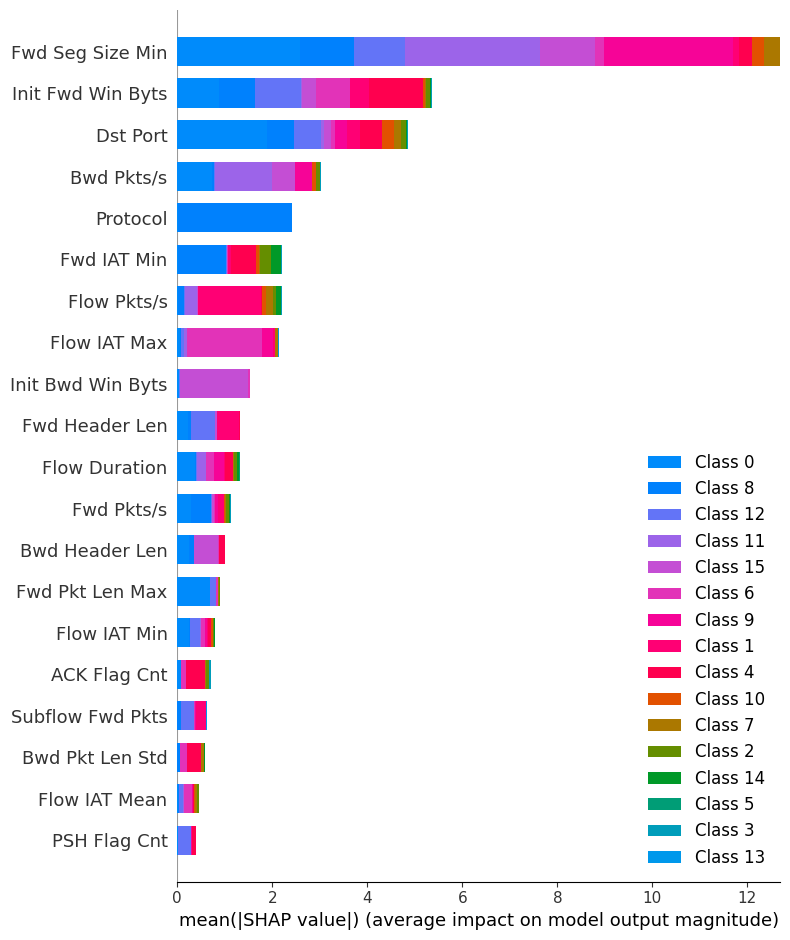

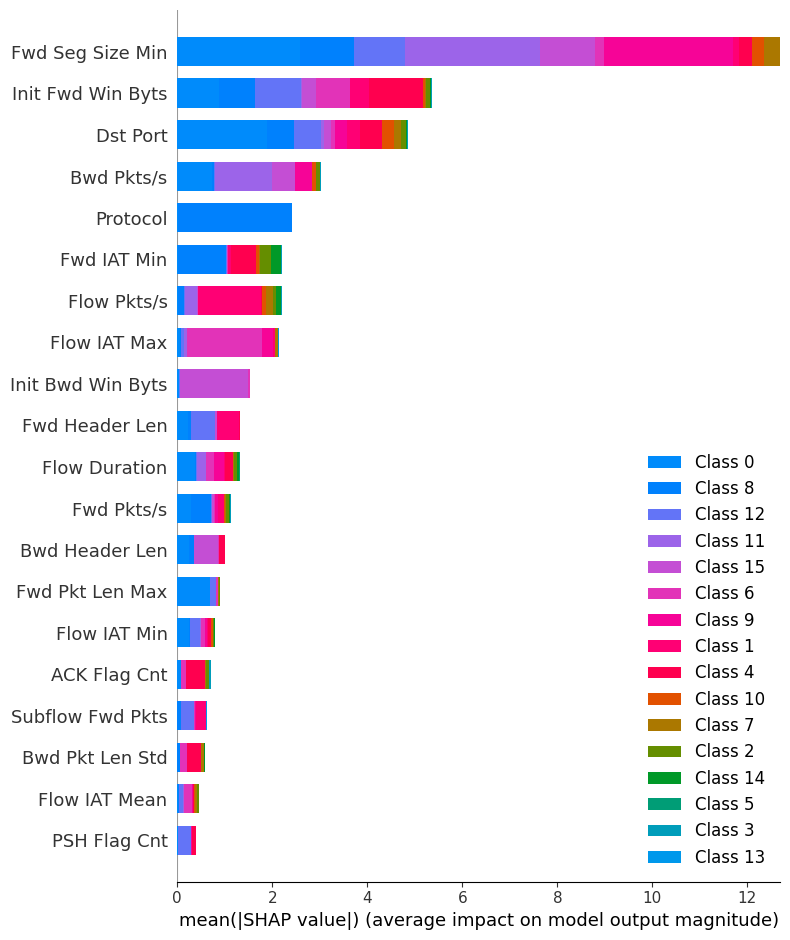

In [31]:
# SHAP explanability

# Make sure to use the same feature order!
with open(os.path.join(ARTIFACT_DIR, "feature_names.json")) as f:
    all_features = json.load(f)

df_sample = pd.read_csv(MERGED_CSV_PATH, nrows=10000)
labels = df_sample['Label'].astype(str).apply(map_labels)
df_sample = df_sample.drop(columns=['Label'])
df_sample = preprocess_chunk(df_sample)
df_sample = df_sample.reindex(columns=all_features, fill_value=0)

explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(df_sample)

os.makedirs(ARTIFACT_DIR, exist_ok=True)

plt.figure()
shap.summary_plot(shap_values, df_sample, show=False)
plt.savefig(os.path.join(ARTIFACT_DIR, "shap_summary.png"), bbox_inches="tight")

plt.figure()
shap.summary_plot(shap_values, df_sample, plot_type="bar", show=False)
plt.savefig(os.path.join(ARTIFACT_DIR, "shap_bar.png"), bbox_inches="tight")

print("Artifacts saved in:", ARTIFACT_DIR)


In [32]:
print("Training features:", bst.num_features())
print("SHAP input features:", df_sample.shape[1])

Training features: 70
SHAP input features: 70
